# Yelp Pulse

##### Generating Positive vs Negative Mentions from Yelp reviews for deeper sentiment understanding, leveraging LDA and BERT.

Hypothetical Requirement: [https://github.com/clement-hironimus/yelp-pulse-sentiment-analysis/blob/main/README.md](https://github.com/clement-hironimus/yelp-pulse-sentiment-analysis/blob/main/README.md)
&nbsp;

What does this Jupyter Notebook contain?

Step 1: Data Preprocessing
1. Load Libraries, Load Data, Check Column Semantic & Types
2. Check Duplicates & Missing Values
3. Cleaning Text Data

Step 2: Exploratory Data Analysis (EDA)
1. Sentiment Distribution Analysis
2. Business Attributes Analysis
3. Review Length and Engagement

Step 3: Topic Extraction and Sentiment Classification
1. Topic Extraction using LDA
2. Initial Sentiment Classification Using DistilBERT
3. Segmentation and Sentiment Classification at the Topic Level

Step 4: Model Building and Tuning
1. LSTM Model Development
2. Training the LSTM Model
3. Model Tuning and Validation

Step 5: Manual Validation and Refinement
1. Random Sample Selection for Manual Validation
2. Manual Review and Labeling
3. Model Refinement

## Step 1. Data Preprocessing

Let's assume that "TODAY" is Jan 2022 as indicated from the latest Yelp review data.

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# For text preprocessing
import re # RegEx
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
import emoji # To convert emojis into text (eg. emoji.demojize('😊') ===> will return ":smiling_face_with_smiling_eyes:")
from langdetect import detect # Detecting a language


### Load Yelp Dataset

Dataset Documentation: [https://www.yelp.com/dataset/documentation/main](https://www.yelp.com/dataset/documentation/main)

&nbsp;
<img src="yelp_dataset/dataset_info.png" alt="Yelp Dataset Info" style="height: 200px; width: auto; display: block; margin-left: auto; margin-right: auto;">

#### Load Yelp Review Data

Containing reviews from "2005-02-16" to "2022-01-19".

Column semantic & value example

```
{
    // string, 22 character unique review id
    "review_id": "zdSx_SD6obEhz9VrW9uAWA",

    // string, 22 character unique user id, maps to the user in user.json
    "user_id": "Ha3iJu77CxlrFm-vQRs_8g",

    // string, 22 character business id, maps to business in business.json
    "business_id": "tnhfDv5Il8EaGSXZGiuQGg",

    // integer, star rating
    "stars": 4,

    // string, date formatted YYYY-MM-DD
    "date": "2016-03-09",

    // string, the review itself
    "text": "Great place to hang out after work: the prices are decent, and the ambience is fun. It's a bit loud, but very lively. The staff is friendly, and the food is good. They have a good selection of drinks.",

    // integer, number of useful votes received
    "useful": 0,

    // integer, number of funny votes received
    "funny": 0,

    // integer, number of cool votes received
    "cool": 0
}
```

This step involves loading the Yelp review data and filtering it to only include reviews from the years 2017 to 2021. I'm excluding data from 2022 as it contains only reviews from January, which could introduce biases due to incomplete representation of the year—particularly relevant if seasonality affects review patterns. Additionally, reviews older than 2017 are excluded to manage the dataset’s size and focus the analysis on more recent reviews, which are likely more relevant to current trends and business practices.

In [2]:
# Load Yelp Reviews
df_yelp_review = pd.read_json(
    'yelp_dataset/yelp_academic_dataset_review.json', 
    lines=True  # Using "lines" because each line in the file is a separate JSON object
)

# Convert 'date' column to datetime format to facilitate filtering
df_yelp_review['date'] = pd.to_datetime(df_yelp_review['date'])

# Filter reviews to include only those from 2017 to 2021
df_yelp_review = df_yelp_review[df_yelp_review['date'].dt.year.between(2017, 2021)]

# Show data preview and the new rows & columns count after filtering
print(f'Rows & Cols count after filtering: {df_yelp_review.shape}')
df_yelp_review.head()


Rows & Cols count after filtering: (3806440, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
24,lUUhg8ltDsUZ9h0xnwY4Dg,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4,1,0,1,I was really between 3 and 4 stars for this on...,2018-07-17 03:30:07
30,-P5E9BYUaK7s3PwBF5oAyg,Jha0USGDMefGFRLik_xFQg,bMratNjTG5ZFEA6hVyr-xQ,5,0,0,0,First time there and it was excellent!!! It fe...,2017-02-19 13:32:05
31,YbMyvlDA2W3Py5lTz8VK-A,4hBhtCSgoxkrFgHa4YAD-w,bbEXAEFr4RYHLlZ-HFssTA,5,0,0,0,"Great burgers,fries and salad! Burgers have a...",2017-01-02 03:17:34


In [3]:
# Renaming some columns for more clarity, specifying all columns to make sure column names are compatible with the rest of this notebook
df_yelp_review.rename(
    columns={
        'review_id': 'review_id',
        'user_id': 'user_id',
        'business_id': 'business_id',
        'stars': 'review_stars',
        'useful': 'review_useful_count',
        'funny': 'review_funny_count',
        'cool': 'review_cool_count',
        'text': 'review_text',
        'date': 'review_date'
    },
    inplace=True
)

In [4]:
# Quick data summary & confirming date filter
df_yelp_review.describe()

,review_stars,review_useful_count,review_funny_count,review_cool_count,review_date
count,3.806440e+06,3.806440e+06,3.806440e+06,3.806440e+06,3806440
mean,3.764915e+00,9.738512e-01,2.404268e-01,4.704919e-01,2019-04-17 13:57:20.745206272
min,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,2017-01-01 00:00:35
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2018-02-26 02:04:26.750000128
50%,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019-03-12 16:47:41
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2020-05-20 14:03:59.249999872
max,5.000000e+00,9.330000e+02,7.920000e+02,3.040000e+02,2021-12-31 23:59:26
std,1.546930e+00,2.936411e+00,1.410730e+00,2.267318e+00,NaN


In [5]:
# Show the data size for each year
pd.DataFrame(
    df_yelp_review.groupby(df_yelp_review['review_date'].dt.year).size(),
    columns=['data_size']
)

,data_size
review_date,
2017,820048
2018,906362
2019,907284
2020,554557
2021,618189


#### Load Yelp Business Data

Column semantic & value example

```
{
    // string, 22 character unique string business id
    "business_id": "tnhfDv5Il8EaGSXZGiuQGg",

    // string, the business's name
    "name": "Garaje",

    // string, the full address of the business
    "address": "475 3rd St",

    // string, the city
    "city": "San Francisco",

    // string, 2 character state code, if applicable
    "state": "CA",

    // string, the postal code
    "postal code": "94107",

    // float, latitude
    "latitude": 37.7817529521,

    // float, longitude
    "longitude": -122.39612197,

    // float, star rating, rounded to half-stars
    "stars": 4.5,

    // integer, number of reviews
    "review_count": 1198,

    // integer, 0 or 1 for closed or open, respectively
    "is_open": 1,

    // object, business attributes to values. note: some attribute values might be objects
    "attributes": {
        "RestaurantsTakeOut": true,
        "BusinessParking": {
            "garage": false,
            "street": true,
            "validated": false,
            "lot": false,
            "valet": false
        },
    },

    // an array of strings of business categories
    "categories": [
        "Mexican",
        "Burgers",
        "Gastropubs"
    ],

    // an object of key day to value hours, hours are using a 24hr clock
    "hours": {
        "Monday": "10:00-21:00",
        "Tuesday": "10:00-21:00",
        "Friday": "10:00-21:00",
        "Wednesday": "10:00-21:00",
        "Thursday": "10:00-21:00",
        "Sunday": "11:00-18:00",
        "Saturday": "10:00-21:00"
    }
}
```



In [6]:
# Load Yelp Business
df_yelp_business = pd.read_json(
    'yelp_dataset/yelp_academic_dataset_business.json', 
    lines=True # Using "lines" because each line in the file is a separate JSON object
)

# Show data preview
print(f'Rows & Cols count: {df_yelp_business.shape}')
df_yelp_business.head()

Rows & Cols count: (150346, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [7]:
# Renaming some columns for more clarity, specifying all columns to make sure column names are compatible with the rest of this notebook
df_yelp_business.rename(
    columns={
        'business_id': 'business_id',
        'name': 'business_name',
        'address': 'business_address',
        'city': 'business_city',
        'state': 'business_state',
        'postal_code': 'business_postal_code',
        'latitude': 'business_latitude',
        'longitude': 'business_longitude',
        'stars': 'business_average_review_stars',
        'review_count': 'business_review_count',
        'is_open': 'is_business_open',
        'attributes': 'business_attributes',
        'categories': 'business_categories',
        'hours': 'business_hours'
    },
    inplace=True
)

### Check Column Types

In [8]:
# df_yelp_review
print(df_yelp_review.dtypes)

review_id                      object
user_id                        object
business_id                    object
review_stars                    int64
review_useful_count             int64
review_funny_count              int64
review_cool_count               int64
review_text                    object
review_date            datetime64[ns]
dtype: object


In [9]:
# df_yelp_business
print(df_yelp_business.dtypes)

business_id                       object
business_name                     object
business_address                  object
business_city                     object
business_state                    object
business_postal_code              object
business_latitude                float64
business_longitude               float64
business_average_review_stars    float64
business_review_count              int64
is_business_open                   int64
business_attributes               object
business_categories               object
business_hours                    object
dtype: object


### Check for Duplicates

In [10]:
# Function to show random duplicate examples
def get_random_dupe_sample(df, dupe_col_subset, dupe_sample_count, col_to_include_in_dupe_sample):
    
    # Identify all duplicates based on 'user_id' and 'review_text'
    is_duplicated = df.duplicated(subset=dupe_col_subset, keep=False)
    print(f"All rows containing duplicates: {is_duplicated.sum()} of {len(df)} total rows")
    
    print("Sample of duplicate records:")
    # Group by 'user_id' and 'review_text' and sample X group randomly
    return df[is_duplicated].groupby(dupe_col_subset, group_keys=False)[col_to_include_in_dupe_sample].apply(
        lambda x: x.sample(min(len(x), dupe_sample_count))
    )

#### Duplicates in "df_yelp_review"

Despite no duplicates found by "review_id" among the 3.8 million rows, there are suspicious cases of duplication (note that categories #1 and #2 may overlap):

1. By review_text (18,400 rows): It's unlikely for two different users to post identical long reviews, although there can be instances where different users post the same short reviews (e.g., "Great service!").
2. By user_id and review_text (17,900 rows): These duplicates indicate a higher likelihood of repeated posts by the same users.

Based on these observations, I will remove duplicates identified in category #2 only. This decision leaves out the remaining 500 cases from category #1. While these could potentially skew the sentiment analysis, they are retained because if they represent valid identical reviews from different users, their contributions should still be weighted in the sentiment analysis.

In [11]:
# Check if there are duplicates by "review_id"
print(df_yelp_review['review_id'].duplicated().sum())

0


In [12]:
get_random_dupe_sample(
    df=df_yelp_review, 
    dupe_col_subset=['review_text'], 
    dupe_sample_count=10, 
    col_to_include_in_dupe_sample=['user_id', 'review_text', 'business_id', 'review_date']
)

All rows containing duplicates: 18415 of 3806440 total rows
Sample of duplicate records:


,user_id,review_text,business_id,review_date
3897864,5RZDMSpeMNEJcgtgMxzGDQ,!!!!!!!!\n!!!!!!!!\n!!!!!!!Do not eat here \nI...,TjXbh5PwgCOFkvbi0_qrmA,2018-06-26 22:23:27
3753724,5RZDMSpeMNEJcgtgMxzGDQ,!!!!!!!!\n!!!!!!!!\n!!!!!!!Do not eat here \nI...,TjXbh5PwgCOFkvbi0_qrmA,2018-06-06 00:52:54
4083345,dWu1E1lmdFZF7P621TPSEQ,"""Burger of the Moment"" Do it! It is fantastic!...",CySqUcNz8oPiQTu4EXTnig,2021-10-09 19:07:15
4135424,dWu1E1lmdFZF7P621TPSEQ,"""Burger of the Moment"" Do it! It is fantastic!...",CySqUcNz8oPiQTu4EXTnig,2021-10-12 23:29:05
586767,Xf5hPJl9P4r9rRAy-NR46g,"""Prep's Breakfast Sammie"" is the BEST breakfas...",UCMSWPqzXjd7QHq7v8PJjQ,2020-09-10 20:10:14
...,...,...,...,...
3324665,nQqtZcL5IZnkfz50Egmq8Q,yay! for the impossible burger!!!\nBK Lounge ...,TNwooHYZ_R0w8Zhoeb51iA,2019-11-05 13:26:00
4391575,hSGexBI1k5mD-Vp6t2A-9w,两星纯粹是给味道，可以称之为SB地区最正宗的中餐馆。扣的三星完全是因为服务态度。桌子不擦，上...,v_8DrVtUIHE0o62Ps926Yg,2018-03-11 07:45:34
4338044,hSGexBI1k5mD-Vp6t2A-9w,两星纯粹是给味道，可以称之为SB地区最正宗的中餐馆。扣的三星完全是因为服务态度。桌子不擦，上...,v_8DrVtUIHE0o62Ps926Yg,2018-03-09 22:38:07
3575985,658KY3BAcjeSAK_d2LOMDA,土曜日のブランチに来ました。たくさんの広い席があり自由に座れるので、とてもゆったり座れます。...,8yUdqNLViWhmfbYVltkJ7Q,2017-10-28 14:04:30


In [13]:
get_random_dupe_sample(
    df=df_yelp_review, 
    dupe_col_subset=['user_id', 'review_text'], 
    dupe_sample_count=5, 
    col_to_include_in_dupe_sample=['user_id', 'review_text', 'business_id', 'review_date']
)

All rows containing duplicates: 17909 of 3806440 total rows
Sample of duplicate records:


,user_id,review_text,business_id,review_date
4478223,--6GckBYtTa4hj8pT09oAg,I gave this place two tries. They struck out b...,VTXE1OIWWE-IVFnMEsm39g,2017-12-15 18:25:32
3783248,--6GckBYtTa4hj8pT09oAg,I gave this place two tries. They struck out b...,3ALBXAloMWzu_HoFaNKJkA,2017-12-15 18:22:32
2443418,--rTlRNPla6azelpN66Y6A,Just ate at this place and the food is horribl...,gMLd9wEcsB17vhraoIGydw,2018-03-14 04:48:36
2225400,--rTlRNPla6azelpN66Y6A,Just ate at this place and the food is horribl...,gMLd9wEcsB17vhraoIGydw,2018-03-06 22:51:01
5894290,-0_v1Gvjhsi0AbKmQLdq0g,The food here is absolutely amazing. I've trie...,p3-FsWgkrRlT18Mw5Z1tHg,2018-10-30 15:49:02
...,...,...,...,...
5872135,zyB2nCLs1x27K-sXLj8aDw,This a great little lunch spot tucked away in ...,zwd4dyQ5ovnjVojWfAuhMw,2018-11-08 17:20:34
2671413,zzAJb1SyZKQp5qOQ0EJjxA,I strongly do not recommend this store. I aske...,Blu-xIRaFO7Ktyj3ZHZpdg,2020-11-24 18:06:29
551182,zzAJb1SyZKQp5qOQ0EJjxA,I strongly do not recommend this store. I aske...,7WTy8p_Uc_iVDKugJc59oA,2020-11-24 18:02:45
5236070,zzW56xgATvt0CouuDYxkrA,Horrible service again! I only go here for qui...,mAEA3VaTrvs64VLP2p_SsQ,2019-08-01 22:55:47


In [14]:
print(f"Total rows: {len(df_yelp_review)}")
# This means there are 9,130 duplicates which also include duplicates that happen >2 times 
print(f"Duplicate rows to remove: {df_yelp_review.duplicated(subset=['review_text']).sum()}")

# Remove duplicates: keep the first occurrence, discard subsequent duplicates
df_yelp_review = df_yelp_review.drop_duplicates(subset=['user_id', 'review_text'], keep='first')

print(f"Remaining rows: {len(df_yelp_review)}") # Confirm successful deduplication

Total rows: 3806440
Duplicate rows to remove: 9384
Remaining rows: 3797310


#### "df_yelp_business"

In [15]:
# Check if there are duplicates by "business_id" column
print(df_yelp_business['business_id'].duplicated().sum())

0


I looked browsed these potential duplicates, but there are businesses that happened to be on the same addresses. No strong evidence found that these are duplicates.

In [18]:
get_random_dupe_sample(
    df=df_yelp_business, 
    dupe_col_subset=['business_latitude', 'business_longitude', 'business_address', 'is_business_open'], 
    dupe_sample_count=10, 
    col_to_include_in_dupe_sample=['business_latitude', 'business_longitude', 'business_name', 'business_address', 'is_business_open', 'business_city', 'business_state', 'business_postal_code', 'business_review_count', 'business_average_review_stars']
)

All rows containing duplicates: 9229 of 150346 total rows
Sample of duplicate records:


,business_latitude,business_longitude,business_name,business_address,is_business_open,business_city,business_state,business_postal_code,business_review_count,business_average_review_stars
46265,27.675726,-82.726385,Sea Worthy Fish + Bar,1110 Pinellas Bayway S,1,Tierra Verde,FL,33715,58,4.5
70055,27.675726,-82.726385,Tierra Verde Property Management,1110 Pinellas Bayway S,1,Saint Petersburg,FL,33715,6,1.5
7017,27.695851,-82.453611,Lil Swimmers Aquatics,,1,Ruskin,FL,33570,7,4.5
133400,27.695851,-82.453611,Bob Billa's SHJ Plumbing,,1,Ruskin,FL,33570,5,3.5
142969,27.695851,-82.453611,It's Time Auto Detailing,,1,Ruskin,FL,33570,26,4.5
...,...,...,...,...,...,...,...,...,...,...
107041,53.561002,-113.563625,TELUS World of Science,11211 142 Street NW,1,Edmonton,AB,T5M 4A1,11,3.5
10409,53.570634,-113.416455,Uncle Ed's Restaurant,4824 118 Avenue NW,1,Edmonton,AB,T5W 1B4,60,4.0
1117,53.570634,-113.416455,Mundare Sausage House,4824 118 Avenue NW,1,Edmonton,AB,T5W 1B4,7,4.0
32355,53.634785,-113.626740,Vinyl Rock Cafe,24 Perron Street,0,Saint Albert,AB,T8N 1E7,5,3.5


However, if adding "name" as duplicate condition, there are very few dupes found. However, I'm not excluding these because each review is connected with "business_id" and we want to make sure these reviews will have the business information when joining with this table. 

In [19]:
get_random_dupe_sample(
    df=df_yelp_business, 
    dupe_col_subset=['business_latitude', 'business_longitude', 'business_name', 'business_address', 'is_business_open'], 
    dupe_sample_count=10, 
    col_to_include_in_dupe_sample=['business_latitude', 'business_longitude', 'business_name', 'business_address', 'is_business_open', 'business_city', 'business_state', 'business_postal_code', 'business_review_count', 'business_average_review_stars']
)

All rows containing duplicates: 32 of 150346 total rows
Sample of duplicate records:


,business_latitude,business_longitude,business_name,business_address,is_business_open,business_city,business_state,business_postal_code,business_review_count,business_average_review_stars
132063,27.952747,-82.450809,Tampa Union Station,601 N Nebraska Ave,1,Tampa,FL,33602,21,4.0
48391,27.952747,-82.450809,Tampa Union Station,601 N Nebraska Ave,1,Tampa,FL,33602,19,3.0
74227,29.982484,-90.114553,Lake Lawn Metairie Funeral Home & Cemeteries,5100 Pontchartrain Blvd,1,New Orleans,LA,70124,39,4.5
63945,29.982484,-90.114553,Lake Lawn Metairie Funeral Home & Cemeteries,5100 Pontchartrain Blvd,1,New Orleans,LA,70124,17,5.0
113827,30.005173,-90.105275,Lakeview Grocery,801 Harrison Ave,1,New Orleans,LA,70124,48,3.5
92261,30.005173,-90.105275,Lakeview Grocery,801 Harrison Ave,1,New Orleans,LA,70124,13,3.5
124926,30.016263,-90.199632,Robert’s Fresh Market,5016 W Esplanade Ave,1,Metairie,LA,70006,16,3.0
149608,30.016263,-90.199632,Robert’s Fresh Market,5016 W Esplanade Ave,1,Metairie,LA,70006,8,3.0
6087,32.251708,-110.890542,Cupcakes,"4811 E Grant Rd, Ste 127",0,Tucson,AZ,85712,6,3.0
28944,32.251708,-110.890542,Cupcakes,"4811 E Grant Rd, Ste 127",0,Tucson,AZ,85712,27,2.0


### Check Missing Values

In [43]:
# df_yelp_review
df_yelp_review.isna().sum().sort_values(ascending=False)

review_useful_count    3
review_funny_count     2
review_cool_count      1
review_id              0
user_id                0
business_id            0
review_stars           0
review_text            0
review_date            0
cleaned_review_text    0
dtype: int64

These columns would likely be used more as secondary information when they're presented in the final dashboard, and not for model/text review analysis. Will revisit in EDA if these columns would be used for the model.

In [21]:
#df_yelp_business
print(f'Total rows: {len(df_yelp_business)}')
print('Count of missing values:')
missing_data = pd.concat(
    [
    df_yelp_business.isna().sum().sort_values(ascending=False),
    df_yelp_business.isna().mean() * 100
    ],
    axis=1
)
missing_data.columns = ['total', '%']
missing_data

Total rows: 150346
Count of missing values:


,total,%
business_hours,23223,15.446370
business_attributes,13744,9.141580
business_categories,103,0.068509
business_id,0,0.000000
business_name,0,0.000000
business_address,0,0.000000
business_city,0,0.000000
business_state,0,0.000000
business_postal_code,0,0.000000
business_latitude,0,0.000000


In [41]:
df_yelp_business.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_average_review_stars,business_review_count,is_business_open,business_attributes,business_categories,business_hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

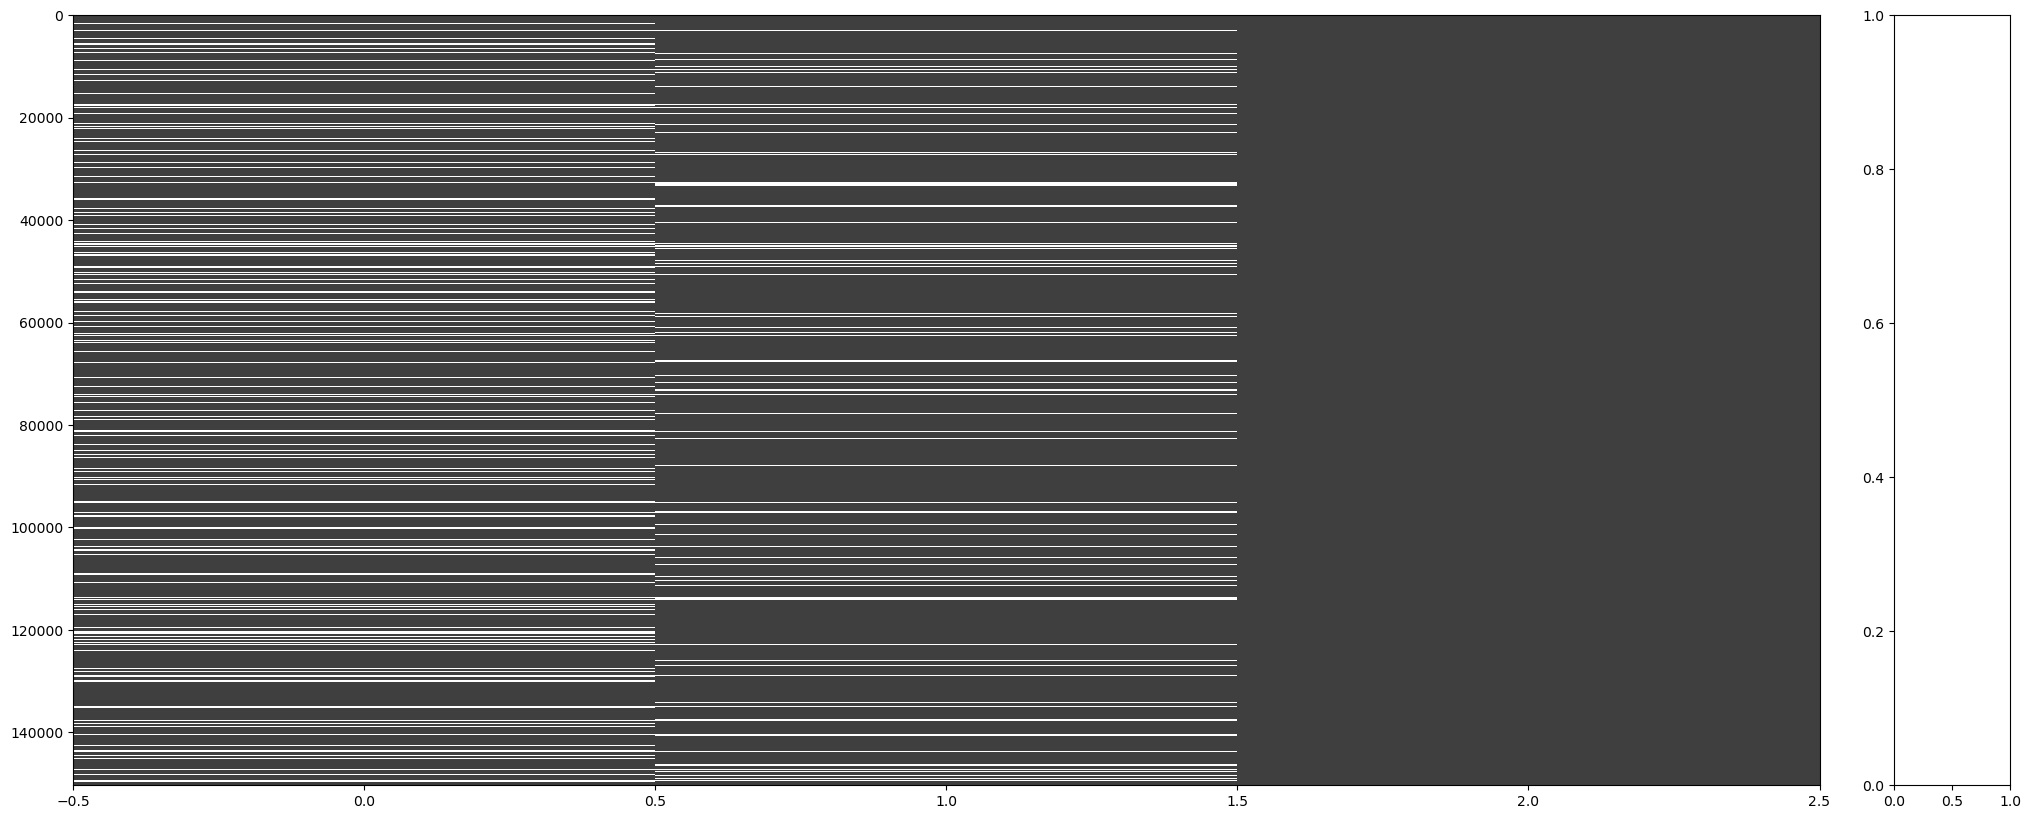

In [42]:
import missingno as msno
# To check if missing values are due to randomness
_ = msno.matrix(df_yelp_business[['business_hours', 'business_attributes', 'business_categories']])

### Check for Business with No Reviews

Need to excluding them to reduce the data size since we won't be able to use the data for model training (no reviews).

In [24]:
# Check if there are businesses without reviews
business_with_no_review = df_yelp_business[(df_yelp_business['business_review_count'] == 0) | (df_yelp_business['business_review_count'].isna())]
print(f'Count of businesses without reviews: {len(business_with_no_review)} of {len(df_yelp_business)} total')

Count of businesses without reviews: 0 of 150346 total


### Quick check for obvious anomalies

There are very rare cases where the useful/funny/cool counts are negative (4 out of 3.80M rows). For now I'm just correcting them to NaN as the other columns `review_text` and `review_stars` looked valid/useful.

In [25]:
df_yelp_review.describe()

,review_stars,review_useful_count,review_funny_count,review_cool_count,review_date
count,3.797310e+06,3.797310e+06,3.797310e+06,3.797310e+06,3797310
mean,3.765176e+00,9.741646e-01,2.405979e-01,4.707680e-01,2019-04-17 22:02:54.739929088
min,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,2017-01-01 00:00:35
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2018-02-26 04:37:26.750000128
50%,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019-03-12 22:53:12
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2020-05-21 19:34:18
max,5.000000e+00,9.330000e+02,7.920000e+02,3.040000e+02,2021-12-31 23:59:26
std,1.546696e+00,2.938160e+00,1.411966e+00,2.269119e+00,NaN


In [28]:
is_count_negative = (df_yelp_review['review_useful_count'] < 0) | (df_yelp_review['review_funny_count'] < 0) | (df_yelp_review['review_cool_count'] < 0)
df_yelp_review[is_count_negative]

,review_id,user_id,business_id,review_stars,review_useful_count,review_funny_count,review_cool_count,review_text,review_date
1933674,plhadSWfXZFKRAhEztb6Dw,0Q4ouqkcwrVE_Im6a6Tomw,SJQePJL1bkeEk-6gp-6eeA,1,-1,0,0,This complaint has nothing to do with the qual...,2018-12-23 01:35:31
2046381,iYS4pfUCUPT_TEmW6BOnrA,1p8Pu1pvAsuNtuZDtn2OkQ,SJQePJL1bkeEk-6gp-6eeA,3,-1,0,0,Having been to bouncy places across the countr...,2017-01-18 18:11:15
2201840,JcWLycg0Hdsz6LBNAqS37A,04j3r2Psfw_LxX1UXPhnyg,E3Qk7xTznkT0SABL2ltpHA,5,-1,-1,-1,The food was so much better than I expected. T...,2017-10-05 02:47:33
4383627,7tlF2NEDiFqMRjKBgTPJ3g,VKK7pPl6DfjL9H5b3n2yCA,qjstXewt23oCZnf86CsHXg,1,2,-1,2,The most horrible removal company I have ever ...,2017-02-25 23:40:34


In [29]:
# Convert negative counts to NaN
cols_to_check = ['review_useful_count', 'review_funny_count', 'review_cool_count']
for col in cols_to_check:
    df_yelp_review.loc[df_yelp_review[col] < 0, col] = np.nan

# Confirm NaN conversion was successful
df_yelp_review[is_count_negative]

,review_id,user_id,business_id,review_stars,review_useful_count,review_funny_count,review_cool_count,review_text,review_date
1933674,plhadSWfXZFKRAhEztb6Dw,0Q4ouqkcwrVE_Im6a6Tomw,SJQePJL1bkeEk-6gp-6eeA,1,NaN,0.0,0.0,This complaint has nothing to do with the qual...,2018-12-23 01:35:31
2046381,iYS4pfUCUPT_TEmW6BOnrA,1p8Pu1pvAsuNtuZDtn2OkQ,SJQePJL1bkeEk-6gp-6eeA,3,NaN,0.0,0.0,Having been to bouncy places across the countr...,2017-01-18 18:11:15
2201840,JcWLycg0Hdsz6LBNAqS37A,04j3r2Psfw_LxX1UXPhnyg,E3Qk7xTznkT0SABL2ltpHA,5,NaN,NaN,NaN,The food was so much better than I expected. T...,2017-10-05 02:47:33
4383627,7tlF2NEDiFqMRjKBgTPJ3g,VKK7pPl6DfjL9H5b3n2yCA,qjstXewt23oCZnf86CsHXg,1,2.0,NaN,2.0,The most horrible removal company I have ever ...,2017-02-25 23:40:34


No obvious issues found when looking at "df_yelp_business"

In [30]:
df_yelp_business.describe()

,business_latitude,business_longitude,business_average_review_stars,business_review_count,is_business_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


### Text Cleaning for LDA and DistilBERT

Since we'll use both LDA and DistilBERT, our text cleaning strategy is designed to balance clarity for topic modeling and preserving contextual nuance for sentiment analysis.

&nbsp;
### Key Steps:

1. **Case Normalization**:
    Ensure consistency in casing to reduce vocabulary size.

2. **Emoji Conversion**:
    Convert emojis to readable text to preserve their emotional and semantic content (eg. 😊 becomes "happy_face")

3. **Special Characters and URL Removal**: 
    Remove URLs & non-essential characters that do not contribute to topic modeling or sentiment analysis.

4. **Lemmatization and Stopword Removal**: 
    Reduce words to their base forms and remove common stopwords to focus on significant words for LDA, utilizing NLTK's `WordNetLemmatizer` and filter out stopwords. (eg. Am/Are/Is --> Be ; Car, Cars, Car's --> Car; Mice --> Mouse ; Went --> Go)

In [31]:
# Pre-compile these Regex Patterns so we don't have to re-compile on every loop (especially considering millions of rows)
regex_patterns = {
    'urls': re.compile(r'https?://\S+|www\.\S+'),
    'special_chars': re.compile(r'[^A-Za-z0-9\s]+'),
    'numbers': re.compile(r'\d+'),
    'extra_spaces': re.compile(r'\s+') 
}

def clean_text(text):
    # Normalize text to lowercase
    text = text.lower()
    
    # Remove URLs and replace them with a space to avoid concatenation issues
    text = regex_patterns['urls'].sub(' ', text)
    
    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    # Remove special characters and replace them with a space
    text = regex_patterns['special_chars'].sub(' ', text)
    
    # Remove numbers and replace them with a space if they are not part of a word
    text = regex_patterns['numbers'].sub(' ', text)
    
    # Replace multiple spaces with a single space to clean up any resulting extra spaces
    text = regex_patterns['extra_spaces'].sub(' ', text).strip()
    
    return text


# Apply the cleaning function using vectorized operations
df_yelp_review['cleaned_review_text'] = df_yelp_review['review_text'].apply(clean_text)

# Removing stopwords and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(text):
    words = text.split()
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply stopword removal and lemmatization
df_yelp_review['cleaned_review_text'] = df_yelp_review['cleaned_review_text'].apply(remove_stopwords_and_lemmatize)

Let's see random examples for each cleaning case

In [37]:
# Sample conditions
conditions = {
    'uppercase': df_yelp_review['review_text'].str.contains(r'[A-Z]'),
    'urls': df_yelp_review['review_text'].str.contains(r'https?://\S+|www\.\S+'),
    'special_characters': df_yelp_review['review_text'].str.contains(r'[^\w\s]'),
    'numbers': df_yelp_review['review_text'].str.contains(r'\d'),
    'extra_spaces': df_yelp_review['review_text'].str.contains(r'\s+')
}

# Creating a DataFrame to store samples
sampled_data = pd.DataFrame()

for category, condition in conditions.items():
    sampled_category = df_yelp_review[condition].sample(n=2, random_state=42)[['review_text', 'cleaned_review_text']]
    sampled_category['cleaning_case'] = category
    sampled_data = pd.concat([sampled_data, sampled_category], axis=0) # Append the new sample to "sampled_data" dataframe

sampled_data.reset_index(drop=True, inplace=True) # Reset index for more clarity
sampled_data[['cleaning_case', 'review_text', 'cleaned_review_text']]

,cleaning_case,review_text,cleaned_review_text
0,uppercase,Friendly staff and very engaging. I also like ...,friendly staff engaging also like preferred ha...
1,uppercase,I used to come here often when I worked in Pal...,used come often worked palm harbor found area ...
2,urls,I cannot imagine a more heavy-handed group of ...,cannot imagine heavy handed group aspiring naz...
3,urls,"September 19, 2017\n\nI rented a car for a wee...",september rented car week advantage rental car...
4,special_characters,Let me start by saying that I only gave them o...,let start saying gave one star give zero even ...
5,special_characters,I made a few visits to this restaurant in hope...,made visit restaurant hope trying find good ja...
6,numbers,Incredibly poor service from laser esthetician...,incredibly poor service laser esthetician mana...
7,numbers,Customer service was great but the sandwiches ...,customer service great sandwich bland would ha...
8,extra_spaces,"They're friendly, fast and efficient. Doesn't ...",friendly fast efficient get better easy peasy
9,extra_spaces,Horrible experience. They were deployed by AHS...,horrible experience deployed ahs like many rev...


### Detect the review languages

Although the businesses are located in the US, it is essential to verify the languages of the reviews because:
- User Demographics: Customers could be tourists or residents who prefer writing in their native language, reflecting the diverse cultural backdrop of the US.
- Accuracy of Analysis: Using NLP tools specifically designed for English to process text in other languages could lead to incorrect or misleading analysis outcomes.

Given the large dataset of 3.7 million rows, we are processing the data in batches of 1000 rows each to enhance efficiency, considering:
- Efficiency: Processing in smaller batches allows more manageable memory usage and faster processing times.
- Risk: While there is a minor risk of encountering mixed-language texts within a single batch, this risk is minimal considering each batch represents only about 0.03% of the total dataset. The likelihood of significant language mixing within these small batches is relatively low, thereby ensuring reliable language detection results.

In [33]:
def detect_language(text):
    """Detect language from a given text or return 'error' if detection fails."""
    try:
        return detect(text)
    except Exception:
        return 'error'

# Initial setup, the loop with go from index 0 to dataframe's length by specified number of increments as we're combining them into one text
start_index = 0
increment = 1000
languages = []
total_rows = len(df_yelp_review)

start_time = time.time()

while start_index < total_rows:
    end_index = min(start_index + increment, total_rows)
    print(f'Processing: {start_index} to {end_index}')
    # Concatenate all reviews in the current chunk into a single large string
    chunk = df_yelp_review['review_text'][start_index:end_index].str.cat(sep=' ')
    # Detect language of the concatenated chunk
    languages.append(detect_language(chunk))
    start_index += increment

# Compute total time taken
end_time = time.time()
print(f'Total time taken: {end_time - start_time:.2f} seconds')

# Optional: Store the results into a DataFrame
language_results = pd.DataFrame(languages, columns=['language'])


Processing: 0 to 1000
Processing: 1000 to 2000
Processing: 2000 to 3000
Processing: 3000 to 4000
Processing: 4000 to 5000
Processing: 5000 to 6000
Processing: 6000 to 7000
Processing: 7000 to 8000
Processing: 8000 to 9000
Processing: 9000 to 10000
Processing: 10000 to 11000
Processing: 11000 to 12000
Processing: 12000 to 13000
Processing: 13000 to 14000
Processing: 14000 to 15000
Processing: 15000 to 16000
Processing: 16000 to 17000
Processing: 17000 to 18000
Processing: 18000 to 19000
Processing: 19000 to 20000
Processing: 20000 to 21000
Processing: 21000 to 22000
Processing: 22000 to 23000
Processing: 23000 to 24000
Processing: 24000 to 25000
Processing: 25000 to 26000
Processing: 26000 to 27000
Processing: 27000 to 28000
Processing: 28000 to 29000
Processing: 29000 to 30000
Processing: 30000 to 31000
Processing: 31000 to 32000
Processing: 32000 to 33000
Processing: 33000 to 34000
Processing: 34000 to 35000
Processing: 35000 to 36000
Processing: 36000 to 37000
Processing: 37000 to 38

### Merge the Clean Dataset
Method: `df_yelp_review` LEFT JOIN `df_yelp_business` ON `business_id`

In [45]:
# Before joining, double check if there's null on either table's key
print(f"""Checking nulls on 'business_id' column
df_yelp_review: {df_yelp_review['business_id'].isnull().sum()}
df_yelp_business: {df_yelp_business['business_id'].isnull().sum()}
""")

Checking nulls on 'business_id' column
df_yelp_review: 0
df_yelp_business: 0


In [46]:
# Perform LEFT JOIN, keeping only needed rows
df_clean_yelp_review_and_business = df_yelp_review.merge(
    df_yelp_business, 
    on='business_id', 
    how='left'
)[[
    # User Review
    'cleaned_review_text',
    'review_date',
    'review_stars',
    'review_useful_count',
    'review_funny_count',
    'review_cool_count',
    
    # Business Info
    'business_name',
    'business_average_review_stars',
    'business_review_count',
    'business_address',
    'is_business_open',
    'business_categories',
    'business_city',
    'business_state',
    'business_postal_code'
]]

# Show the result
df_clean_yelp_review_and_business.head()

,cleaned_review_text,review_date,review_stars,review_useful_count,review_funny_count,review_cool_count,business_name,business_average_review_stars,business_review_count,business_address,is_business_open,business_categories,business_city,business_state,business_postal_code
0,decide eat aware going take hour beginning end...,2018-07-07 22:09:11,3,0.0,0.0,0.0,Turning Point of North Wales,3.0,169,1460 Bethlehem Pike,1,"Restaurants, Breakfast & Brunch, Food, Juice B...",North Wales,PA,19454
1,cute interior owner gave u tour upcoming patio...,2017-01-14 20:54:15,4,1.0,0.0,1.0,Melt,4.0,32,2549 Banks St,0,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",New Orleans,LA,70119
2,really star one love th street naked tchopstix...,2018-07-17 03:30:07,4,1.0,0.0,1.0,Naked Tchopstix Express,3.5,33,"2902 W 86th St, Ste 70",0,"Restaurants, Food, Poke, Hawaiian, Sushi Bars",Indianapolis,IN,46268
3,first time excellent feel like entering someon...,2017-02-19 13:32:05,5,0.0,0.0,0.0,Portobello Cafe,4.0,137,1423 Chester Pike,1,"Restaurants, Seafood, Cafes, Italian",Eddystone,PA,19022
4,great burger fry salad burger hint salt pepper...,2017-01-02 03:17:34,5,0.0,0.0,0.0,The Original Habit Burger Grill,4.0,329,5735 Hollister Ave,1,"Fast Food, Burgers, Restaurants",Goleta,CA,93117


## Step 2: Exploratory Data Analysis (EDA)

### Create Review-Level Sentiment Label

In [ ]:
# Create the column

In [ ]:
# Quick visualization/distribution


### Checking Outliers

#### Numerical Outliers

### Categorical Outliers

Also for possible categorical imbalances

### Date-based Outliers

Join the two dataframes

In [ ]:
# Before joining, double check if there's null on either table's key
print(f"""Checking nulls on 'business_id' column
df_yelp_review: {df_yelp_review['business_id'].isnull().sum()}
df_yelp_business: {df_yelp_business['business_id'].isnull().sum()}
""")

In [ ]:
# Join table and only include the columns needed

# Putting "df_yelp_review" on the left side because we'll need all the reviews to train the model
df_yelp_review_and_business = df_yelp_review.merge(
    df_yelp_business,
    on='business_id',
    how='left'
)

## 4. Summary

In [ ]:
# Final checks before saving
# print(df.info())
# print(df.describe())

## Save the Cleaned Data

In [ ]:
# To save the data
# df.to_csv('file_name.json', index=False)